In [ ]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from torch.utils.data import DataLoader
import timm
from torchinfo import summary
from rich.pretty import pprint
import torch.optim as optim
import torch
import time
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Introduction
In this project, we use convolutional neural networks (CNNs) to classify images of wheat into different categories, such as normal, broken, moldy, etc. We train 4 different models and achieve >99% F1 scores on the classification.

The paper describing the data-gathering process and the dataset in detail can be found [here](https://www.nature.com/articles/s41597-023-02660-8).

More details and code from the paper can be found [here](git@github.com:hellodfan/GrainSet.git).

We focus entirely on wheat data, for which the data can be found [here](https://figshare.com/articles/figure/wheat_zip/22992317/2). 

The data comes already split into a training (90%) and test set (10%), corresponding to 180k and 20k images respectively. We will hold out the test set in training and split the training set into training and validation (70% to 30%). Cross-validation was not feasible with this dataset due to computational constraints.

# Exploratory Data Analysis (EDA)

In [3]:
def get_class_label(path: str) -> str:
    return os.path.basename(path).split("_")[1]


In [4]:
# Assemble lists of files for every class as well as class labels
train_path = "../GrainSetData/wheat/train"
test_path = "../GrainSetData/wheat/test"
paths = sorted(glob.glob(f"{train_path}/*"))
classes = dict([z.split("_")[::-1] for z in [os.path.basename(x) for x in paths]])
classes = {k: int(v) for k, v in classes.items()}


In [5]:
# Save a list of training images. We do not use them during training
# except to ensure that they are not included in train/val datasets
test_images = []
for k in os.listdir(test_path):
    test_images.extend(
        [os.path.basename(x).split(".")[0] for x in glob.glob(f"{test_path}/{k}/*.png")]
    )

The data comes with a metadata file that describes _all_ data.


In [6]:
df_meta = pd.read_xml("../GrainSetData/wheat/wheat.xml")

In [7]:
# Sort the data in the same order as the classes
df_meta["prio"] = pd.Categorical(df_meta["DU_grain"], categories=classes, ordered=True)
df_meta = df_meta.sort_values("prio")

In [8]:
# Let's inspect the metadata:
df_meta.head()

,ID,species,sub-species,location,time,size,DU_grain,weight,prio
99999,Grainset_wheat_2021-06-08-17-16-55_12_p600s,wheat,hexaploid common,CN,2017-02-25,15,NOR,40,NOR
105995,Grainset_wheat_2022-01-07-14-55-20_17_p600s,wheat,hexaploid common,USA,2017-08-02,19,NOR,54,NOR
105996,Grainset_wheat_2022-08-26-15-05-05_12_p600s,wheat,hexaploid common,CN,2016-02-16,18,NOR,47,NOR
105997,Grainset_wheat_2021-08-14-15-57-17_24_p600s,wheat,hexaploid common,USA,2016-02-15,15,NOR,40,NOR
105998,Grainset_wheat_2021-09-20-09-46-38_12_p600s,wheat,hexaploid common,CN,2019-07-02,16,NOR,44,NOR


In [9]:
df_meta[["species", "sub-species", "location", "DU_grain"]].apply(pd.unique)

species                                   [wheat]
sub-species                    [hexaploid common]
location                       [CN, USA, AU, CAN]
DU_grain       [NOR, F&S, SD, MY, AP, BN, BP, IM]
dtype: object

From this quick inspection, we find the definitions of various columns:

* ID: path to the file
* species: the species of the grain - in our case, it's always "wheat"
* sub-species: the subspecies of the grain - in our case, it's always "hexaploid common"
* location: where grain is from (four options: AU - Australia,  CAN - Canada, CN - China, USA - USA)
* size: the area of the grain, in ${\rm mm}^{2}$ 
* DU_grain: this is the state of the grain, aka the grain class, which we will predict
    * NOR - normal
    * F&S - fusarium and shriveled: kernels attacked by fungi from the Fusarium genus. As a result, these grains may contain _toxic_ substances and have a strong negative effect on food safety
    * SD - sprouted: grains in the process of germinating
    * MY - moldy: grains contaminated by mold or fungi (other than Fusarium)
    * BN - broken: kernels that have been physically fractured
    * AP - attacked by pests: kernels that have been infested by pests (insects of various kinds)
    * BP - black point: kernels that have been affected by fungal infections or insect damage
    * IM - impurity: not actually wheat, but some other material/debris which was not filtered out during processing
* weight: the weight in grams

The goal of our analysis is to use the images identified by the ID and train the model to predict the DU_grain class.

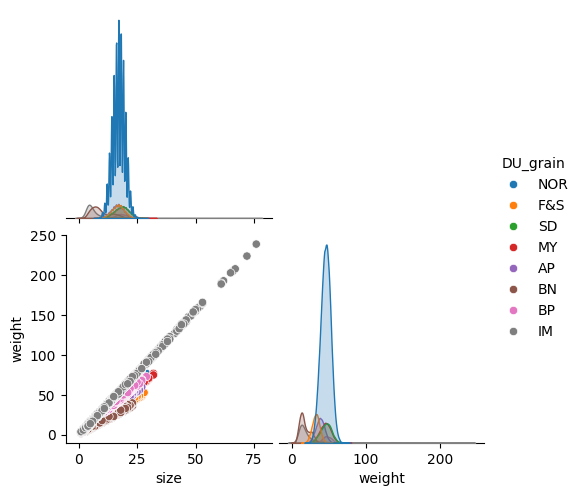

In [10]:
# Let's take a quick look at the physical characteristics of the different classes
pp = sns.pairplot(df_meta[["size", "weight", "DU_grain"]], hue="DU_grain", corner=True)

We can see there is quite a bit of overlap between some of the classes - separating them out purely based on physical characteristics would be difficult.

<Axes: xlabel='DU_grain', ylabel='Count'>

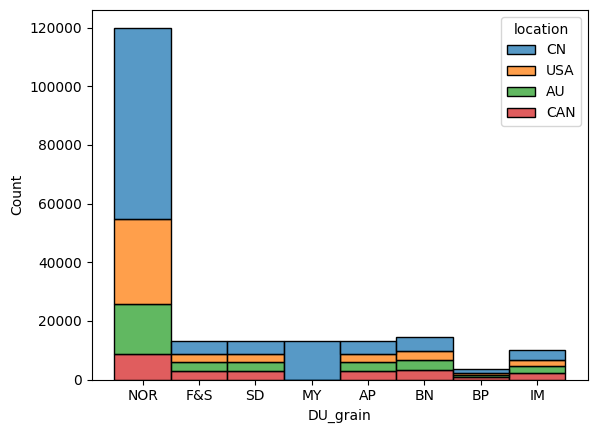

In [11]:
# Plot the distribution of classes
sns.histplot(df_meta, x="DU_grain", hue="location", multiple="stack")

It's clear that we have **unbalanced** classes: there are far more samples in the normal category than there are in the others. This is entirely expected as most grains are in nominal condition. Thus we will need to be careful when assessing the accuracy of our classifier, and use the F1 score and not just the raw accuracy.

In [12]:
classes

{'NOR': 0, 'F&S': 1, 'SD': 2, 'MY': 3, 'AP': 4, 'BN': 5, 'BP': 6, 'IM': 7}

In [13]:
class_meanings = [
    "Normal",
    "Fusarium",
    "Sprouted",
    "Moldy",
    "Attacked by pests",
    "Broken",
    "Black point",
    "Impurities",
]
class_explanations = dict(zip(classes.keys(), class_meanings))

Let's take a look at the actual image data, by loading 1 image from every category.

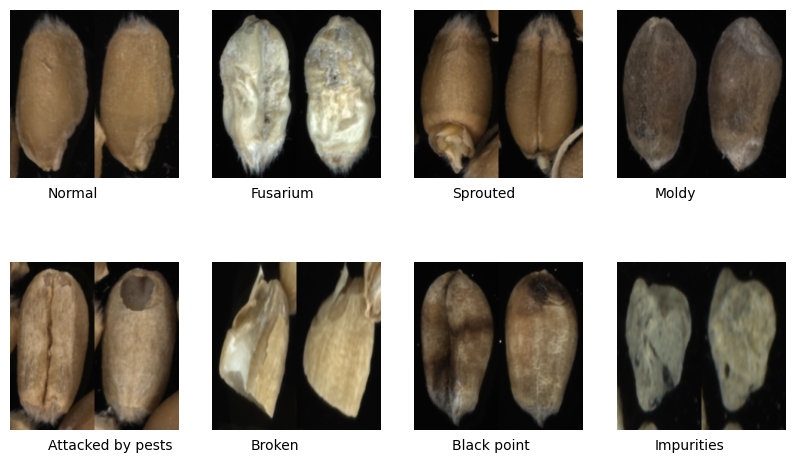

In [14]:
fig, axs = plt.subplots(2, 4, figsize=(10, 6))
axs = axs.flat
size = (224, 224)
for i, (cls, num) in enumerate(classes.items()):
    pth = os.path.join(train_path, f"{num}_{cls}")
    img_pth = sorted(glob.glob(f"{pth}/*"))[2]
    image = Image.open(img_pth).convert("RGB")
    image = image.resize(size, Image.Resampling.LANCZOS)
    axs[i].imshow(image)
    axs[i].text(50, 250, class_explanations[cls])
    axs[i].set_axis_off()

A few things to note:
* each image consists of both an up and a down view
* the original images are _not_ the same size and must be resized. **NOTE: we will always resize the images to 224x224 size**
* some images may have other grains in the background
* there are indeed visual indicators of the different grain states. That is exactly what our classifier should learn.

# Preparing the data

The first thing we do is split the data in the training directory into training and validation. This will help us:

* tune any hyperparameters
* assess which of the models we train should be selected to be trained on the entire dataset

We choose to split the training set into 70% training and 30% validation. This results in ~120k images for training and ~60k images for validation.

In [15]:
from sklearn.model_selection import train_test_split
import numpy as np

random_state = 42
val_frac = 0.3

In [16]:
# The metadata file contains all data, including testing. We exclude testing files here
df_meta_train = df_meta[~df_meta["ID"].isin(test_images)].reset_index(drop=True)
df_meta_test = df_meta[df_meta["ID"].isin(test_images)].reset_index(drop=True)

In [17]:
# Save lists of training and validation data, performing the split
df_meta_train["label"] = df_meta_train["DU_grain"].map(classes)

df_meta_train["img_path"] = (
    f"{train_path}/"
    + df_meta_train["label"].astype(str)
    + "_"
    + df_meta_train["DU_grain"]
    + "/"
    + df_meta_train["ID"]
    + ".png"
)


df_train, df_val = train_test_split(
    df_meta_train[["img_path", "label"]],
    test_size=val_frac,
    random_state=random_state,
    stratify=df_meta_train["label"],
)
df_train.to_json("training_list.json", indent=4)
df_val.to_json("validation_list.json", indent=4)


In [18]:
# Save list of the test data
df_meta_test["label"] = df_meta_test["DU_grain"].map(classes)
df_meta_test["img_path"] = (
    f"{test_path}/"
    + df_meta_test["label"].astype(str)
    + "_"
    + df_meta_test["DU_grain"]
    + "/"
    + df_meta_test["ID"]
    + ".png"
)
df_meta_test[["img_path", "label"]].to_json("test_list.json", indent=4)

In [19]:
# Save the entire training set, for training the final model

df_train_all = pd.concat((df_train, df_val))
df_train_all.to_json("training_all_list.json", indent=4)

Let's check that the distribution of classes is indeed the same between training and validation data

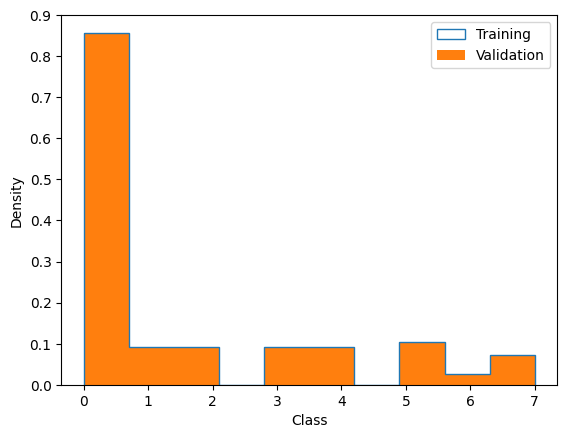

In [20]:
plt.figure()
plt.hist(df_train["label"], density=True, histtype="step", label="Training")
plt.hist(df_val["label"], density=True, label="Validation")
plt.xlabel("Class")
plt.ylabel("Density")
plt.legend(loc=1)

The two map perfectly; so the composition of classes is indeed the same.

# Training models
To start, we will train a very simple, hand-created CNN classifier with very few parameters. While it's unlikely to reach high accuracy, it provides a quick baseline.
Model training will be done in several steps:
- defining all our model and training settings
- building the pytorch CNN model
- creating a DataLoader to load the training and validation data
- defining loss and optimizer
- running the training loop

**Note: The following section will work only if you have downloaded the data!**

## Creating model settings
We must adjust training settings like number of epochs, learning rate, etc. For all our training, we usually use the same settings so we have created them as defaults. See [training_config.py](./training_config.py).

In [67]:
from training_config import TrainingConfig

raw_conf = {"model_name": "BaselineCNNClassifier", "num_epochs": 5, "pretrained": False}
training_config = TrainingConfig(**raw_conf)

In [68]:
pprint(training_config)

TrainingConfig(
│   model_name='BaselineCNNClassifier',
│   pretrained=False,
│   num_epochs=5,
│   batch_size=128,
│   optimization=OptimizationConfig(weight_decay=0.0001, learning_rate=0.0001),
│   n_classes=8,
│   n_workers=4
)

## Constructing the model

In [69]:
from typing import Any
import torch.nn as nn
import torch.nn.functional as F


class BaselineCNNClassifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # input is (3,224,224)
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1
        )
        # (32,224,224)
        self.pool1 = nn.MaxPool2d((2, 2), 2)
        # (32,112,112)
        self.conv2 = nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1
        )
        # (64,112,112)
        self.pool2 = nn.MaxPool2d((2, 2), 2)
        # (64,56,56)
        self.conv3 = nn.Conv2d(
            in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1
        )
        # (64,56,56)
        self.pool3 = nn.MaxPool2d((2, 2), 2)
        # (64,28,28)
        self.fc1 = nn.Linear(64 * 28 * 28, len(classes))

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x

In [70]:
baseline_model = BaselineCNNClassifier()

In [71]:
summary(baseline_model, input_size=(1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
BaselineCNNClassifier                    [1, 8]                    --
├─Conv2d: 1-1                            [1, 32, 224, 224]         896
├─MaxPool2d: 1-2                         [1, 32, 112, 112]         --
├─Conv2d: 1-3                            [1, 64, 112, 112]         18,496
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Conv2d: 1-5                            [1, 64, 56, 56]           36,928
├─MaxPool2d: 1-6                         [1, 64, 28, 28]           --
├─Linear: 1-7                            [1, 8]                    401,416
Total params: 457,736
Trainable params: 457,736
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 393.18
Input size (MB): 0.60
Forward/backward pass size (MB): 20.87
Params size (MB): 1.83
Estimated Total Size (MB): 23.31

## Loading the data
Here we load the data as well as define several image augmentations, namely:
- resizing the image to 224x224
- for training:
    - random affine transformation with rotation, shear and scaling
    - random horizontal flip
- converting to tensor
- normalizing using the settings from ImageNet

In [72]:
from data_loader import prepare_dataset

In [73]:
train_dataset = prepare_dataset(
    "train_list.json", model_name=training_config.model_name
)
val_dataset = prepare_dataset(
    "validation_list.json", model_name=training_config.model_name
)

train_loader = DataLoader(
    train_dataset,
    batch_size=training_config.batch_size,
    shuffle=True,
    num_workers=training_config.n_workers,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2,
)
val_loader = DataLoader(
    val_dataset,
    batch_size=training_config.batch_size,
    shuffle=False,
    num_workers=training_config.n_workers,
    pin_memory=True,
    persistent_workers=True,
)

## Preparing the optimizer

In [74]:
optimizer = optim.Adam(
    baseline_model.parameters(),
    lr=training_config.optimization.learning_rate,
    weight_decay=training_config.optimization.weight_decay,
)
criterion = nn.CrossEntropyLoss()  # Does not need a softmax in the last layer!


## Training loop
Now we train the model. During training we also:
- evaluate the loss and accuracy on training and validation set
- write the training stats to file
- checkpoint the model so training can be resumed

**Note that even this simple model might take a while to train on a T4. The training for the project was done on AMD RX6090XT 16GB consumer graphics card. The training run took 15 minutes.**

In [75]:
from utils import write_model_checkpoint, write_model_training_stats

# Scaler is needed to scale the gradient to avoid underflow, since
# we are training using fp16
scaler = torch.amp.GradScaler("cuda")
# Choose the GPU or the CPU (note: CPU training is **very** slow)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Compile the model for extra speed
model = torch.compile(baseline_model)
# Put the model on the device. The 'memory_format' option is an
# opitmization for AMD GPUs
model.to(device, memory_format=torch.channels_last)


start_epoch = 0
print_freq = 100  # How frequently to print information

print("Beginning the training loop")
for epoch in range(start_epoch, training_config.num_epochs):
    # Training phase
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    # Iterate over the training data
    iteration = 0
    start_time = time.time()
    for inputs, labels in train_loader:
        # Move data to the specified device (GPU or CPU)

        inputs, labels = (
            inputs.to(device, memory_format=torch.channels_last, non_blocking=True),
            labels.to(device, non_blocking=True),
        )

        # Zero the parameter gradients to prevent accumulation
        optimizer.zero_grad()
        # Forward pass
        with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
            outputs = model(inputs)
            # Calculate the loss
            loss = criterion(outputs, labels)
        # Backward pass and optimize
        if loss is not None:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        if iteration % print_freq == 0:
            print(
                f"Epoch {epoch}: Iteration {iteration}/{len(train_loader)} - Loss: {loss.item():.4f} - Time {time.time() - start_time}"
            )
        # Get predictions
        _, predicted = torch.max(outputs.data, 1)
        # Update total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # Accumulate training loss
        running_loss += loss.item()
        iteration += 1

    # Calculate average training loss and accuracy
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Disable gradient calculation for validation
    with torch.no_grad():
        # Iterate over the validation data
        for inputs, labels in val_loader:
            # Move data to the specified device (GPU or CPU)
            inputs, labels = (
                inputs.to(device, memory_format=torch.channels_last, non_blocking=True),
                labels.to(device, non_blocking=True),
            )
            # Forward pass
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                outputs = model(inputs)
                # Calculate the loss
                loss = criterion(outputs, labels)

            # Accumulate validation loss
            val_loss += loss.item()
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            # Update total and correct predictions
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    val_loss /= len(val_loader)
    val_acc = val_correct / val_total

    print(f"Epoch {epoch + 1}/{training_config.num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    end_time = time.time()
    print(f"Time for epoch = {end_time - start_time}")
    stats = [epoch, train_loss, train_acc, val_loss, val_acc, end_time - start_time]

    if epoch % 2 == 0:
        write_model_checkpoint(model, optimizer, stats, training_config)
    write_model_training_stats(stats, training_config.model_name)

print("Training completed!")

Beginning the training loop


Epoch 0: Iteration 0/985 - Loss: 2.0758 - Time 1.7120144367218018
Epoch 0: Iteration 100/985 - Loss: 1.1647 - Time 23.005263805389404
Epoch 0: Iteration 200/985 - Loss: 0.6668 - Time 44.275927782058716
Epoch 0: Iteration 300/985 - Loss: 0.9413 - Time 65.65997886657715
Epoch 0: Iteration 400/985 - Loss: 0.6936 - Time 87.11129117012024
Epoch 0: Iteration 500/985 - Loss: 0.7929 - Time 108.48021650314331
Epoch 0: Iteration 600/985 - Loss: 0.6146 - Time 129.9054400920868
Epoch 0: Iteration 700/985 - Loss: 0.6547 - Time 151.2781310081482
Epoch 0: Iteration 800/985 - Loss: 0.4725 - Time 172.70157265663147
Epoch 0: Iteration 900/985 - Loss: 0.4902 - Time 194.25585007667542
Epoch 1/5
  Train Loss: 0.7363, Train Acc: 0.7717
  Val Loss: 0.4500, Val Acc: 0.8515
Time for epoch = 272.73467659950256
Epoch 1: Iteration 0/985 - Loss: 0.5341 - Time 0.9308257102966309
Epoch 1: Iteration 100/985 - Loss: 0.4168 - Time 22.281166553497314
Epoch 1: Iteration 200/985 - Loss: 0.3554 - Time 43.64515709877014
Epo

## Validating results
We validate the results by computing several different metrics on the validation set:
- accuracy
- precision
- recall
- F1 score
- confusion matrix

In [76]:
from evaluate_model import evaluate_model

model.eval()
df_trained, val_loss_trained, val_acc_trained = evaluate_model(
    model,
    val_dataset,
    training_config,
    output_file=f"accuracy_{training_config.model_name}_trained.csv",
)

[01/21/26 21:12:00] INFO     Creating data loaders                                             ]8;id=537520;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=45862;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#33\33]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=255305;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=274997;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#49\49]8;;\

[01/21/26 21:13:05] INFO     Done                                                              ]8;id=759511;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=496819;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#76\76]8;;\

                    INFO     Writing labels and predictions to                                 ]8;id=228;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=545215;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#82\82]8;;\
                             accuracy_BaselineCNNClassifier_trained.csv                                            

In [77]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
)

conf_matrix = confusion_matrix(df_trained["labels"], df_trained["preds"])
# Normalize as percent of the right class
conf_matrix_normalized = (
    conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
)

Text(0.5, 47.7222222222222, 'Predicted Label')

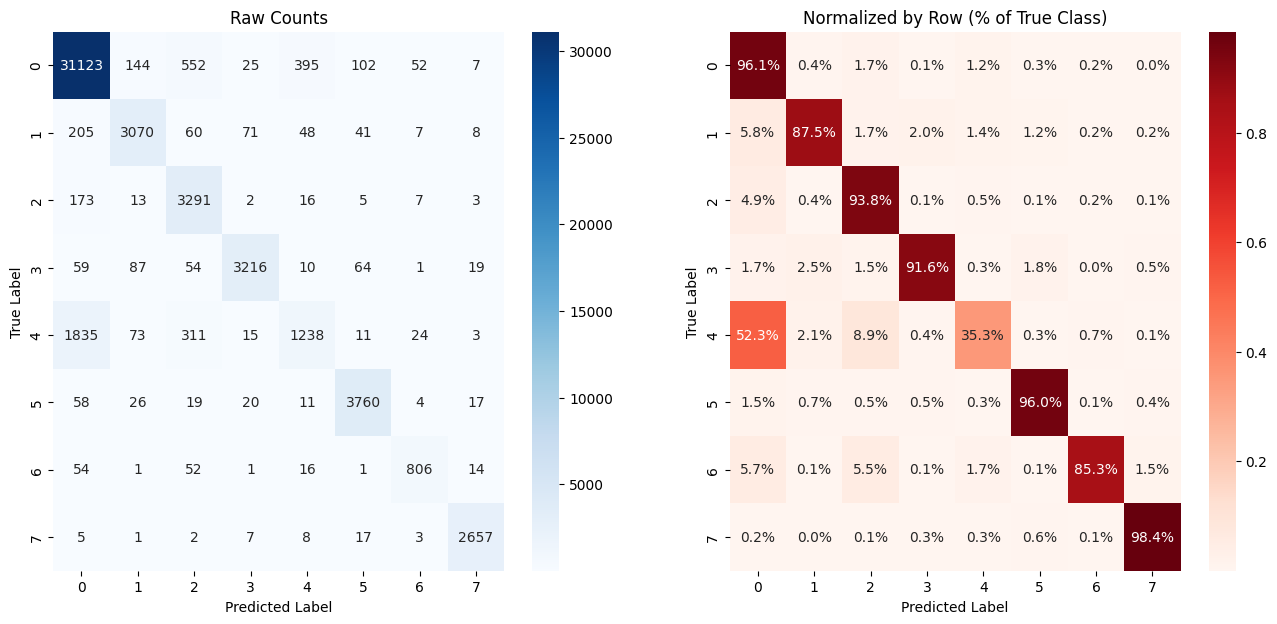

In [78]:
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Raw Counts")
axes[0].set_ylabel("True Label")
axes[0].set_xlabel("Predicted Label")
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".1%", cmap="Reds", ax=axes[1])
axes[1].set_title("Normalized by Row (% of True Class)")
axes[1].set_ylabel("True Label")
axes[1].set_xlabel("Predicted Label")


From the confusion matrices above, it's clear that while for most classes the model already does a fairly good job, that is not the case for images in class 4 which are mostly misclassified as class 0.

In [79]:
precision = precision_score(df_trained["labels"], df_trained["preds"], average="micro")
recall = recall_score(df_trained["labels"], df_trained["preds"], average="micro")
f1 = f1_score(df_trained["labels"], df_trained["preds"], average="micro")
print(f"precision: {precision} - recall: {recall} - f1_score: {f1}")

precision: 0.9103888888888889 - recall: 0.9103888888888889 - f1_score: 0.9103888888888889


As we can see, the results are not great, but that is to be expected from a simple model trained for 3 epochs from scratch. 

To understand what the model is actually learning to discriminate between different classes, we can use`GradCAM` (Gradient-weighted Class Activation Mapping), a visualization technique which allows us to see which parts of the image contribute the most to the classification. `GradCAM` works by looking at the last convolution layer (where the model has learned higher-level concepts like object shapes and other complex patterns) and computing how much each spatial location contributes to the predicted class. This is done by:
1. computing the activations by doing a forward pass through the convolutional layer
2. computing the gradients of the conv layer with respect to a target class
3. computing the mean of the gradients within each output channel
4. computing the weighted average of the activation maps with the gradients being the weights
5. resizing the heatmap back to the size of the original image

 For more information, see the [original paper](https://arxiv.org/abs/1610.02391) and the [pytorch-grad-cam](https://github.com/jacobgil/pytorch-grad-cam?tab=readme-ov-file) library.

In [ ]:
# Pick an image from validation set



In [81]:
from data_loader import get_transforms
from evaluate_model import get_grad_cam

test_image_file = df_val[df_val["label"] == 2]["img_path"].iloc[3]
# Extract the uncompiled model or GradCAM won't work
uncompiled_model = model._orig_mod
uncompiled_model.eval()
uncompiled_model.to("cuda")
val_transforms = get_transforms("val", [0, 0, 0], [1, 1, 1])

# We target the last convolutional layer in our model
target_layers = [uncompiled_model.conv3]

cam = get_grad_cam(
    uncompiled_model,
    test_image_file,
    val_transforms,
    target_layers=target_layers,
)

[01/21/26 21:13:15] INFO     The model predicted class 2                                       ]8;id=420387;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=904474;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#95\95]8;;\

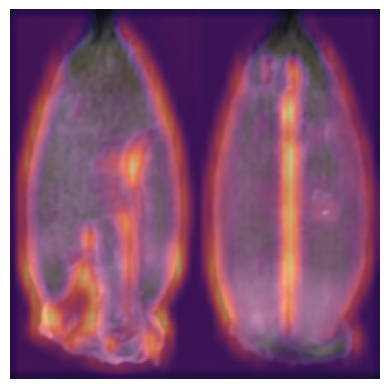

In [82]:
plt.imshow(cam)
plt.axis("off")
plt.show()

Indeed, the model predicted class 2: sprouted - and that is exactly what we see high-lighted in the image.

On the other hand, we find this model makes a complete mess of images from class 4, as can be seen below, where it misclassifies it as class 0, missing entirely the marks of attacks by pests (0 gradient activation in the area where there is pest-damage!).

In [37]:
test_image_file = df_val[df_val["label"] == 4]["img_path"].iloc[3]

cam = get_grad_cam(
    uncompiled_model,
    test_image_file,
    val_transforms,
    target_layers=target_layers,
)

[01/21/26 19:01:58] INFO     The model predicted class 0                                       ]8;id=959769;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=595172;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#95\95]8;;\

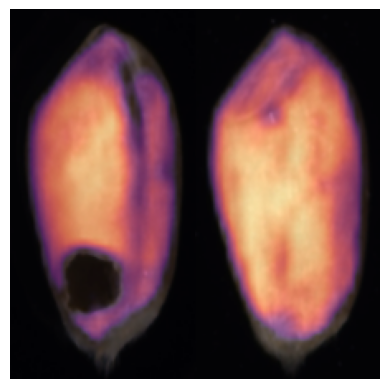

In [38]:
plt.imshow(cam)
plt.axis("off")
plt.show()

Now that we have trained a simple baseline, we proceed to train more advanced models. Due to the expense of training large architectures, we restrict ourselves to models from the `resnet` family: `resnet10`, `resnet18` and `resnet50`. Training such models takes a long time, so we use a script to do this. The resulting trained models are included in this repository. Below, we will simply load the checkpoints and compare the accuracy. To actually run the training we use a script, see [train.py](train.py)



For all models, we start from pretrained models that have already been trained on a large corpus of images (mostly ImageNet). This allows us to take advantage of transfer learning where many of the features that the model would need to learn are already learned. 

To demonstrate the power of transfer learning, consider training `resnet10t` for just 1 (!) epoch.

In [39]:
checkpoint_dir = "checkpoints"
checkpoint_name = "resnet10t_checkpoint_0.pt"
checkpoint = torch.load(
    os.path.join(checkpoint_dir, checkpoint_name), weights_only=True
)


In [40]:
tr_config = TrainingConfig(**checkpoint["training_config"])
epoch = checkpoint["epoch"]
model_state_dict = checkpoint["model_state_dict"]
opitmizer_state_dict = checkpoint["optimizer_state_dict"]
train_loss = checkpoint["train_loss"]
val_loss = checkpoint["val_loss"]

# Note that we have to reinstatiate the validation dataset,
# since it contains the transforms and those are not the same
# between the baseline model and resnet
new_val_dataset = prepare_dataset(
    "validation_list.json", model_name=tr_config.model_name
)
model_trained = timm.create_model(tr_config.model_name, pretrained=True, num_classes=8)
model_trained = torch.compile(model_trained)
model_trained.load_state_dict(checkpoint["model_state_dict"])

model_trained.eval()
df_trained, val_loss_trained, val_acc_trained = evaluate_model(
    model_trained,
    new_val_dataset,
    tr_config,
    output_file=f"accuracy_{tr_config.model_name}_trained.csv",
)

                    INFO     Creating data loaders                                             ]8;id=506628;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=143199;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#33\33]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=735127;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=387468;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#49\49]8;;\

[01/21/26 19:03:07] INFO     Done                                                              ]8;id=375853;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=368149;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#76\76]8;;\

                    INFO     Writing labels and predictions to accuracy_resnet10t_trained.csv  ]8;id=679449;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=280889;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#82\82]8;;\

Text(0.5, 47.7222222222222, 'Predicted Label')

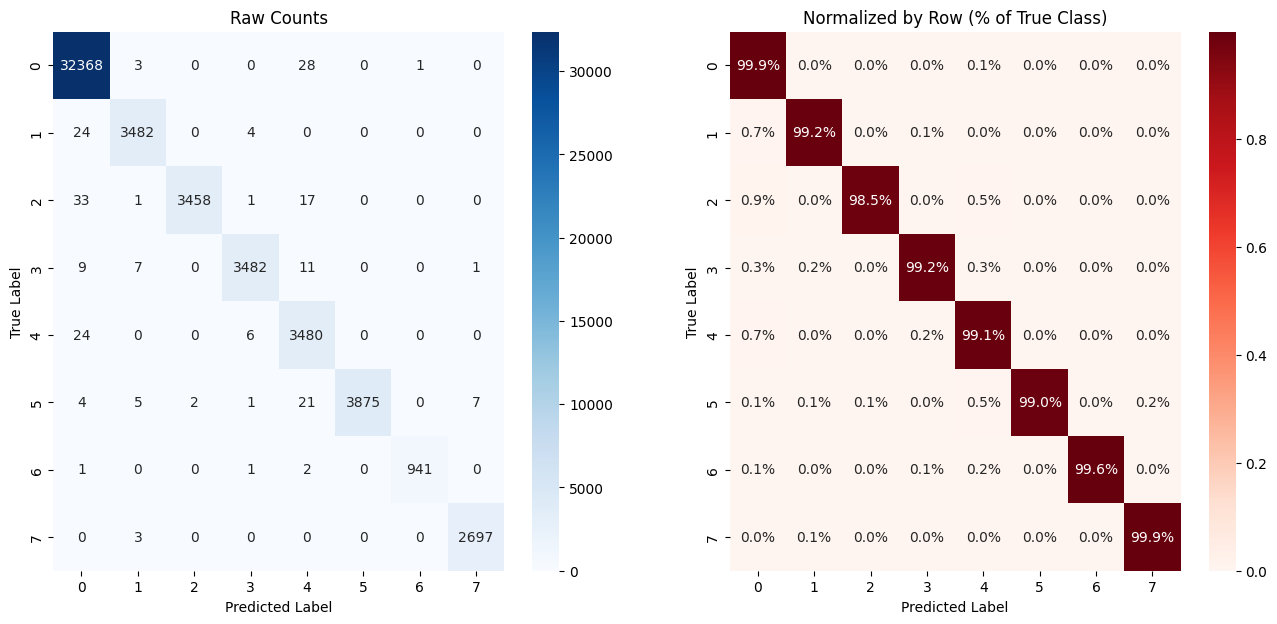

In [41]:
conf_matrix = confusion_matrix(df_trained["labels"], df_trained["preds"])
# Normalize as percent of the right class
conf_matrix_normalized = (
    conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
# Raw counts
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Raw Counts")
axes[0].set_ylabel("True Label")
axes[0].set_xlabel("Predicted Label")
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".1%", cmap="Reds", ax=axes[1])
axes[1].set_title("Normalized by Row (% of True Class)")
axes[1].set_ylabel("True Label")
axes[1].set_xlabel("Predicted Label")

We see that even with just 1 epoch of training `resnet10` achieves excellent results across all classes.

## Tuning parameters
Tuning hyper-parameters is quite expensive but is instructive to see what happens if we change the learning rate for our base model. Suppose we chose a smaller learning rate:

In [42]:
def evaluate_lr(lr):
    baseline_model = BaselineCNNClassifier()
    optimizer = optim.Adam(
        baseline_model.parameters(),
        lr=lr,
        weight_decay=training_config.optimization.weight_decay,
    )
    criterion = nn.CrossEntropyLoss() 
    train_loader = DataLoader(
        train_dataset,
        batch_size=training_config.batch_size,
        shuffle=True,
        num_workers=training_config.n_workers,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=2,
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=training_config.batch_size,
        shuffle=False,
        num_workers=training_config.n_workers,
        pin_memory=True,
        persistent_workers=True,
    )
    # Scaler is needed to scale the gradient to avoid underflow, since
    # we are training using fp16
    scaler = torch.amp.GradScaler("cuda")
    # Choose the GPU or the CPU (note: CPU training is **very** slow)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Compile the model for extra speed
    model = torch.compile(baseline_model)
    # Put the model on the device. The 'memory_format' option is an
    # opitmization for AMD GPUs
    model.to(device, memory_format=torch.channels_last)


    start_epoch = 0
    print_freq = 100  # How frequently to print information

    print("Beginning the training loop")
    for epoch in range(start_epoch, training_config.num_epochs):
        # Training phase
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Iterate over the training data
        iteration = 0
        start_time = time.time()
        for inputs, labels in train_loader:
            # Move data to the specified device (GPU or CPU)

            inputs, labels = (
                inputs.to(device, memory_format=torch.channels_last, non_blocking=True),
                labels.to(device, non_blocking=True),
            )

            # Zero the parameter gradients to prevent accumulation
            optimizer.zero_grad()
            # Forward pass
            with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                outputs = model(inputs)
                # Calculate the loss
                loss = criterion(outputs, labels)
            # Backward pass and optimize
            if loss is not None:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            if iteration % print_freq == 0:
                print(
                    f"Epoch {epoch}: Iteration {iteration}/{len(train_loader)} - Loss: {loss.item():.4f} - Time {time.time() - start_time}"
                )
            # Get predictions
            _, predicted = torch.max(outputs.data, 1)
            # Update total and correct predictions
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            # Accumulate training loss
            running_loss += loss.item()
            iteration += 1

        # Calculate average training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total

        # Validation phase
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        # Disable gradient calculation for validation
        with torch.no_grad():
            # Iterate over the validation data
            for inputs, labels in val_loader:
                # Move data to the specified device (GPU or CPU)
                inputs, labels = (
                    inputs.to(device, memory_format=torch.channels_last, non_blocking=True),
                    labels.to(device, non_blocking=True),
                )
                # Forward pass
                with torch.amp.autocast(device_type="cuda", dtype=torch.float16):
                    outputs = model(inputs)
                    # Calculate the loss
                    loss = criterion(outputs, labels)

                # Accumulate validation loss
                val_loss += loss.item()
                # Get predictions
                _, predicted = torch.max(outputs.data, 1)
                # Update total and correct predictions
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Calculate average validation loss and accuracy
        val_loss /= len(val_loader)
        val_acc = val_correct / val_total

        print(f"Epoch {epoch + 1}/{training_config.num_epochs}")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        end_time = time.time()
        print(f"Time for epoch = {end_time - start_time}")
        stats = [epoch, train_loss, train_acc, val_loss, val_acc, end_time - start_time]

        if epoch % 2 == 0:
            write_model_checkpoint(model, optimizer, stats, training_config)
        write_model_training_stats(stats, f"{training_config.model_name}_{lr}")

    print("Training completed!")
    return model,val_loss,val_acc

In [43]:
m1,loss1,acc1 = evaluate_lr(1e-5)

Beginning the training loop


Epoch 0: Iteration 0/985 - Loss: 2.0854 - Time 1.1841557025909424
Epoch 0: Iteration 100/985 - Loss: 1.6040 - Time 22.95502209663391
Epoch 0: Iteration 200/985 - Loss: 1.2227 - Time 44.78903889656067
Epoch 0: Iteration 300/985 - Loss: 1.4736 - Time 66.6232259273529
Epoch 0: Iteration 400/985 - Loss: 1.3557 - Time 88.4772641658783
Epoch 0: Iteration 500/985 - Loss: 1.2623 - Time 110.23248887062073
Epoch 0: Iteration 600/985 - Loss: 1.2418 - Time 132.0748598575592
Epoch 0: Iteration 700/985 - Loss: 1.0232 - Time 153.9167320728302
Epoch 0: Iteration 800/985 - Loss: 0.9866 - Time 175.8006682395935
Epoch 0: Iteration 900/985 - Loss: 0.9211 - Time 197.64066553115845
Epoch 1/5
  Train Loss: 1.2406, Train Acc: 0.6299
  Val Loss: 0.8989, Val Acc: 0.7314
Time for epoch = 277.17519664764404
Epoch 1: Iteration 0/985 - Loss: 0.9017 - Time 0.9475705623626709
Epoch 1: Iteration 100/985 - Loss: 0.9205 - Time 22.707451343536377
Epoch 1: Iteration 200/985 - Loss: 0.9374 - Time 44.42840623855591
Epoch 1:

In [44]:
m1,loss1,acc1 = evaluate_lr(1e-2)

Beginning the training loop
Epoch 0: Iteration 0/985 - Loss: 2.0780 - Time 1.1285409927368164
Epoch 0: Iteration 100/985 - Loss: 1.4043 - Time 22.76604914665222
Epoch 0: Iteration 200/985 - Loss: 1.3007 - Time 44.49274682998657
Epoch 0: Iteration 300/985 - Loss: 0.8864 - Time 66.27726244926453
Epoch 0: Iteration 400/985 - Loss: 0.7023 - Time 87.8782889842987
Epoch 0: Iteration 500/985 - Loss: 0.9385 - Time 109.5705897808075
Epoch 0: Iteration 600/985 - Loss: 0.7719 - Time 131.2178897857666
Epoch 0: Iteration 700/985 - Loss: 0.6819 - Time 152.8487846851349
Epoch 0: Iteration 800/985 - Loss: 0.8482 - Time 174.47135019302368
Epoch 0: Iteration 900/985 - Loss: 0.6997 - Time 196.20878291130066
Epoch 1/5
  Train Loss: 1.2321, Train Acc: 0.7008
  Val Loss: 0.7122, Val Acc: 0.7606
Time for epoch = 275.57313108444214
Epoch 1: Iteration 0/985 - Loss: 0.6208 - Time 0.8208467960357666
Epoch 1: Iteration 100/985 - Loss: 0.5057 - Time 22.205730438232422
Epoch 1: Iteration 200/985 - Loss: 0.9527 - Ti

We see that in both cases while the training phase was proceeding, convergence of training was slower: for learning rate of $1\times 10^{-5}$,  the validation accuracy after 5 epochs was ~0.8, as well as for $1\times 10^{-2}$   compared to ~0.9 when we used our initial value of $1\times10^{-4}$. Thus, we conclude that we should stick with our default value.

# Comparing different models
We used the following models to build our classifier:

- [`resnet10t`](https://huggingface.co/timm/resnet10t.c3_in1k)
- [`resnet18`](https://huggingface.co/timm/resnet18.a1_in1k)
- [`regnety_008`](https://huggingface.co/timm/regnety_008_tv.tv2_in1k/blob/main/README.md)
- [`mobilenetv3_large`](https://huggingface.co/timm/mobilenetv3_large_100.ra_in1k)

They were selected because they achieve good accuracy on ImageNet while being reasonably lightweight and therefore trainable on a consumer-grade GPU.
The training takes a long time, and thus is not done inside this notebook. See the scripts `train_{model name}.sh`. The final checkpoints after 11 epochs are included in this repo in `./checkpoints`.

In [45]:
from utils import reload_model_for_inference
from evaluate_model import compute_accuracy_measures

In [46]:
trained_resnet10, tr_config_resnet10 = reload_model_for_inference(
    os.path.join(checkpoint_dir, "resnet10t_checkpoint_10.pt")
)
trained_resnet18, tr_config_resnet18 = reload_model_for_inference(
    os.path.join(checkpoint_dir, "resnet18_checkpoint_10.pt")
)
trained_regnety008, tr_config_regnety008 = reload_model_for_inference(
    os.path.join(checkpoint_dir, "regnety_008_tv.tv2_in1k_checkpoint_10.pt")
)
trained_mobilenet, tr_config_mobilenet = reload_model_for_inference(
    os.path.join(checkpoint_dir, "mobilenetv3_large_100.ra_in1k_checkpoint_10.pt")
)


In [47]:
# Assess all models on the validation set
df_resnet10, val_loss_resnet10, val_acc_resnet10 = evaluate_model(
    trained_resnet10,
    new_val_dataset,
    tr_config_resnet10,
)

[01/21/26 19:49:02] INFO     Creating data loaders                                             ]8;id=873735;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=136008;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#33\33]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=382502;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=898380;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#49\49]8;;\

[01/21/26 19:50:08] INFO     Done                                                              ]8;id=352054;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=405106;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#76\76]8;;\

In [48]:
df_resnet18, val_loss_resnet18, val_acc_resnet18 = evaluate_model(
    trained_resnet18,
    new_val_dataset,
    tr_config_resnet18,
)


[01/21/26 19:50:09] INFO     Creating data loaders                                             ]8;id=511948;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=277523;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#33\33]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=320070;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=26779;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#49\49]8;;\

[01/21/26 19:51:26] INFO     Done                                                              ]8;id=181417;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=521355;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#76\76]8;;\

In [49]:
df_regnety008, val_loss_regnety008, val_acc_regnety008 = evaluate_model(
    trained_regnety008,
    new_val_dataset,
    tr_config_regnety008,
)

                    INFO     Creating data loaders                                             ]8;id=774311;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=491774;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#33\33]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=461357;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=596779;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#49\49]8;;\

[01/21/26 19:52:54] INFO     Done                                                              ]8;id=74309;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=646437;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#76\76]8;;\

In [50]:
df_mobilenet, val_loss_mobilenet, val_acc_mobilenet = evaluate_model(
    trained_mobilenet,
    new_val_dataset,
    tr_config_mobilenet,
)

                    INFO     Creating data loaders                                             ]8;id=703859;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=410076;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#33\33]8;;\

                    INFO     Computing accuracy measures                                       ]8;id=935002;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=995739;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#49\49]8;;\

[01/21/26 19:54:18] INFO     Done                                                              ]8;id=401266;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=162975;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#76\76]8;;\

In [51]:
def get_number_of_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    return total

In [52]:
names = ["resnet10", "resnet18", "regnety008", "mobilenet100"]
acc_results = [df_resnet10, df_resnet18, df_regnety008, df_mobilenet]
num_params = [
    get_number_of_parameters(trained_resnet10),
    get_number_of_parameters(trained_resnet18),
    get_number_of_parameters(trained_regnety008),
    get_number_of_parameters(trained_mobilenet),
]


In [53]:
nums_data = dict(zip(names, num_params))

In [54]:
accs_data = dict(zip(names, acc_results))

In [55]:
final_val_scores = []
for k, v in accs_data.items():
    tmp = compute_accuracy_measures(v, average="micro")
    final_val_scores.append([k, *tmp, nums_data[k]])
final_val_scores = pd.DataFrame(
    final_val_scores, columns=["model", "precision", "recall", "f1_score", "num_params"]
)

precision: 0.9989074074074074 - recall: 0.9989074074074074 - f1_score: 0.9989074074074074
precision: 0.9986666666666667 - recall: 0.9986666666666667 - f1_score: 0.9986666666666667
precision: 0.9987222222222222 - recall: 0.9987222222222222 - f1_score: 0.9987222222222222
precision: 0.9982037037037037 - recall: 0.9982037037037037 - f1_score: 0.9982037037037037


In [56]:
final_val_scores.sort_values("f1_score", ascending=False)

,model,precision,recall,f1_score,num_params
0,resnet10,0.998907,0.998907,0.998907,4926592
2,regnety008,0.998722,0.998722,0.998722,5653792
1,resnet18,0.998667,0.998667,0.998667,11180616
3,mobilenet100,0.998204,0.998204,0.998204,4212280


Looking at the results, there is basically _no meaningful difference_ between the models. It might be interesting to examine the confusion matrices to see if a particular model has an advantage there.

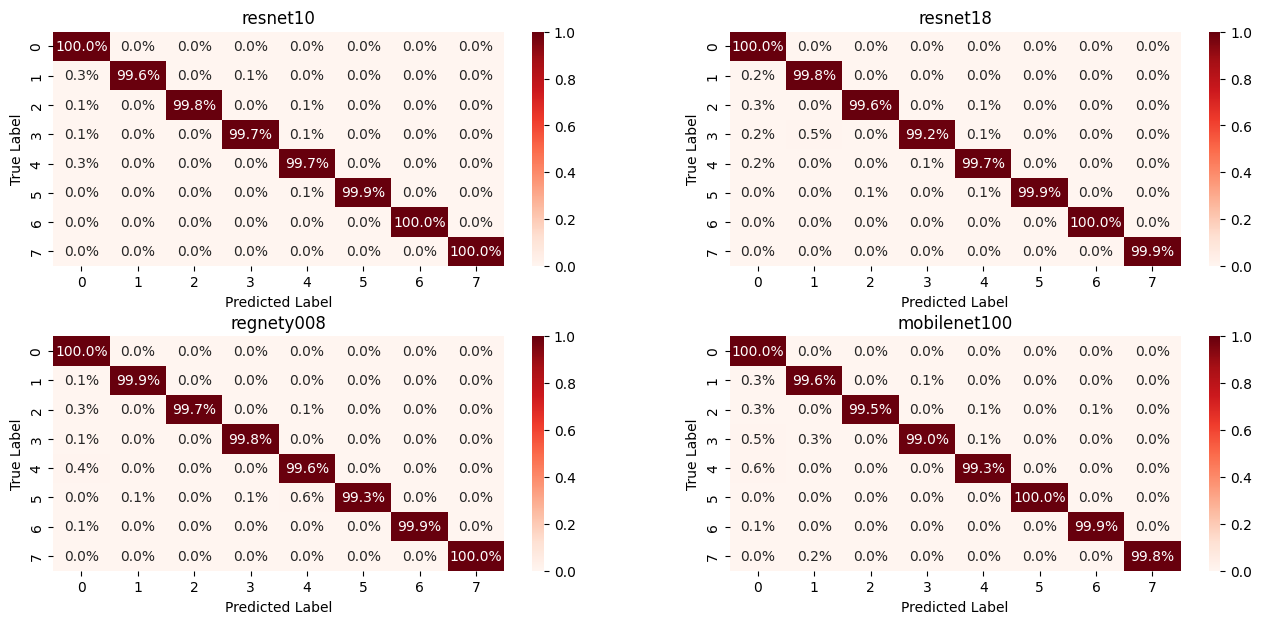

In [57]:
fig, axes = plt.subplots(2, 2, figsize=(16, 7))
axes = axes.flatten()
for i, (k, v) in enumerate(accs_data.items()):
    conf_matrix = confusion_matrix(v["labels"], v["preds"])
    # Normalize as percent of the right class
    conf_matrix_normalized = (
        conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
    )

    # Raw counts
    sns.heatmap(
        conf_matrix_normalized,
        annot=True,
        fmt=".1%",
        cmap="Reds",
        ax=axes[i],
        vmin=0,
        vmax=1,
    )
    axes[i].set_title("Normalized by Row (% of True Class)")
    axes[i].set_ylabel("True Label")
    axes[i].set_xlabel("Predicted Label")
    axes[i].set_title(k)

plt.subplots_adjust(hspace=0.3)

There are very few differences here as well and the numbers could easily change on the level we see here if we were to pick a different validation set. Still, considering average performance across all classes, and taking into account the number of parameters, we select `resnet10` since it achieves very good results while having the 2nd lowest number of parameters (a good tradeoff as we plan for inference serving).

# Evaluate final model on test set
We now train our model on the whole training set. Given the already excellent performance of the model above, we don't start from scratch but continue from the trained model. See [script](train_final_resnet.sh).

In [58]:
final_model, final_config = reload_model_for_inference(
    "./checkpoints/resnet10t_final.pt"
)

In [59]:
test_dataset = prepare_dataset(
    "test_list.json", model_name=tr_config_resnet10.model_name
)

In [60]:
df_final, val_loss_final, val_acc_final = evaluate_model(
    final_model,
    test_dataset,
    final_config,
)

[01/21/26 19:54:20] INFO     Creating data loaders                                             ]8;id=183066;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=136701;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#33\33]8;;\

[01/21/26 19:54:21] INFO     Computing accuracy measures                                       ]8;id=574321;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=507455;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#49\49]8;;\

[01/21/26 19:54:46] INFO     Done                                                              ]8;id=939397;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py\evaluate_model.py]8;;\:]8;id=309709;file:///home/sergei/wheat_analysis_capstone/evaluate_model.py#76\76]8;;\

In [61]:
compute_accuracy_measures(df_final, average="micro")

precision: 0.999 - recall: 0.999 - f1_score: 0.999


[0.999, 0.999, 0.999]

We see that our final model has excellent performance on the held-out set. Let's examine the confusion matrix:

Text(0.5, 47.7222222222222, 'Predicted Label')

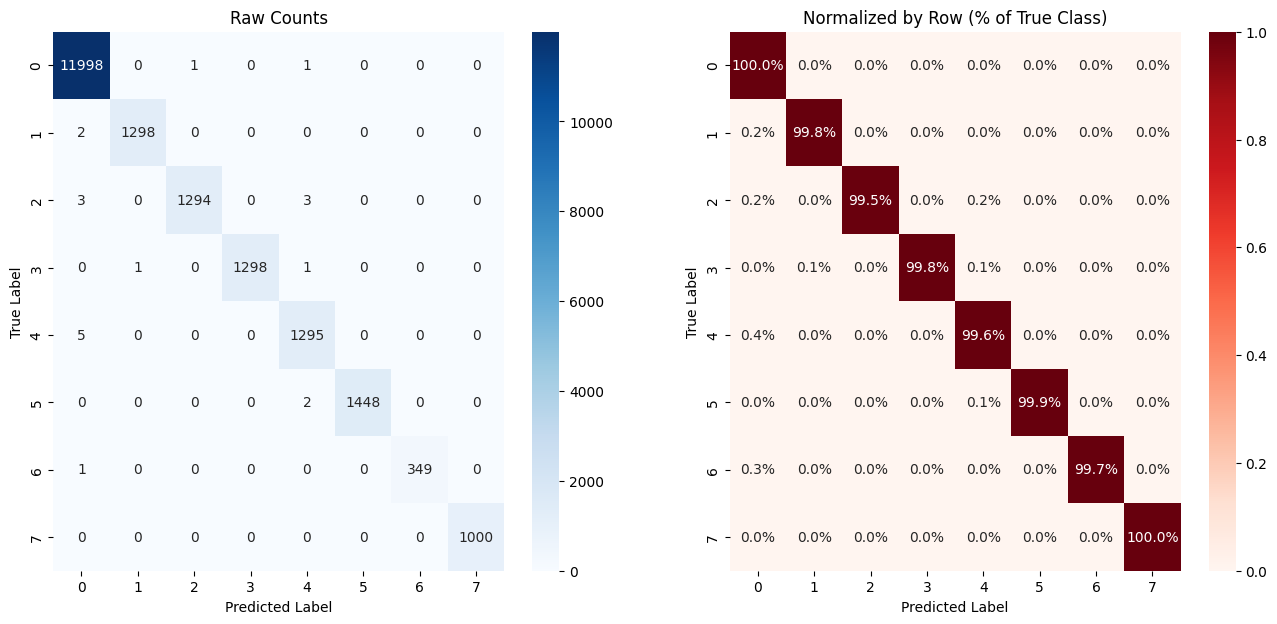

In [62]:
conf_matrix = confusion_matrix(df_final["labels"], df_final["preds"])
# Normalize as percent of the right class
conf_matrix_normalized = (
    conf_matrix.astype("float") / conf_matrix.sum(axis=1)[:, np.newaxis]
)
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
# Raw counts
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Raw Counts")
axes[0].set_ylabel("True Label")
axes[0].set_xlabel("Predicted Label")
sns.heatmap(conf_matrix_normalized, annot=True, fmt=".1%", cmap="Reds", ax=axes[1])
axes[1].set_title("Normalized by Row (% of True Class)")
axes[1].set_ylabel("True Label")
axes[1].set_xlabel("Predicted Label")

Lastly we save our selected model to ONNX format so it can be used easily for inference.

In [63]:
from utils import save_model_to_onnx

In [64]:
save_model_to_onnx(final_model, "resnet10_final", device=device)

[torch.onnx] Obtain model graph for `OptimizedModule([...]` with `torch.export.export(..., strict=False)`...


/home/sergei/envs/ml/lib/python3.12/site-packages/torch/backends/cudnn/__init__.py:175: UserWarning: cuDNN Benchmark limit is not supported in MIOpen and will have no effect. (Triggered internally at /pytorch/torch/csrc/cuda/Module.cpp:1954.)
  torch._C._cuda_set_cudnn_benchmark_limit(_benchmark_limit)


[torch.onnx] Obtain model graph for `OptimizedModule([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


/usr/lib/python3.12/copyreg.py:99: FutureWarning: `isinstance(treespec, LeafSpec)` is deprecated, use `isinstance(treespec, TreeSpec) and treespec.is_leaf()` instead.
  return cls.__new__(cls, *args)


[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 28 of general pattern rewrite rules.
